In [7]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

In [2]:
# TODO: add docstrings for this function
def weather_data_prep() -> pd.DataFrame:
    """
    Loading and preparing the data for further analysis,
    comprising adding column names, selecting the right time range,
    removing columns with only missing values, and concatenating the date and hour
    to make the time format compatible with the bike_counters data.     
    """
    # load weather data of Paris from data folder
    weather_data = pd.read_csv("../data/07156.csv")
    weather_data.columns = [
        "date",
        "hour",
        "temp",
        "dwpt",
        "rhum",
        "prcp",
        "snow",
        "wdir",
        "wspd",
        "wpgt",
        "pres",
        "tsun",
        "coco",
    ]

    # select the column range according the train and test parquet
    # we extended the series a bit longer to the end of the year 2021
    weather_data = weather_data[
        (weather_data.date >= "2020-09-01") & (weather_data.date <= "2021-12-31")
    ]

    # remove columns that are only na's
    weather_data.dropna(axis=1, how="all", inplace=True)

    # concat date and hour together to get a variable to merge bike_counters data
    weather_data["date"] = pd.to_datetime(weather_data.date) + pd.to_timedelta(
        weather_data.hour, unit="h"
    )
    
    return weather_data.drop(columns="hour")

In [3]:
weather_data = weather_data_prep()

In [4]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11604 entries, 180135 to 191738
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  float64       
 4   prcp    10505 non-null  float64       
 5   wdir    11604 non-null  float64       
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 815.9 KB


In [5]:
weather_data.isna().mean()

date    0.000000
temp    0.000000
dwpt    0.000000
rhum    0.000000
prcp    0.094709
wdir    0.000000
wspd    0.000000
pres    0.000000
dtype: float64

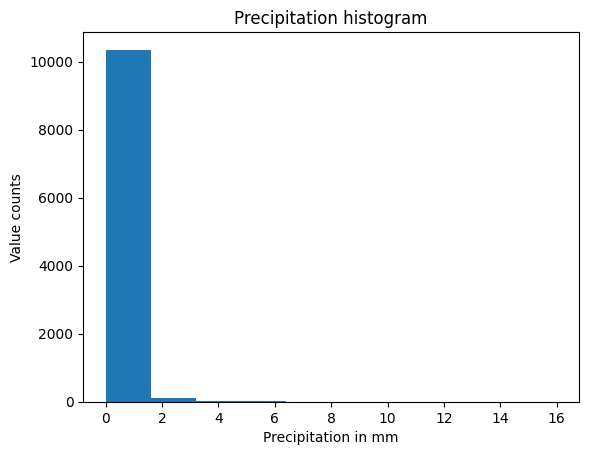

In [13]:
# TODO: plot a histogram before the imputation
plt.hist(weather_data['prcp'],)
plt.xlabel('Precipitation in mm')
plt.ylabel('Value counts')
plt.title('Precipitation histogram')
plt.show()



As we can see above, we did some initial changes to our dataset, namely changing the column names, selecting the date range we are interested in, dropping the columns where all values where *NaN*, and concatenating the date and hour columns in order to have the date in the same formate as the *bike_count*.
After this initial step in preparing our data, we can see that we still have some missing values in the precipitation column (around 10%). In order to tackle this problem, we are going to do multivariate feature amputation in order to predict the missing values. 

In [15]:
# impute percipitation based on all other weather data except the date
imp = IterativeImputer(random_state=0)
transformed_data = imp.fit_transform(weather_data.drop(columns=["date"]))

weather_data_imp = weather_data.copy()
weather_data_imp.iloc[:, 1:] = transformed_data

In [16]:
weather_data_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11604 entries, 180135 to 191738
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  float64       
 4   prcp    11604 non-null  float64       
 5   wdir    11604 non-null  float64       
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 815.9 KB


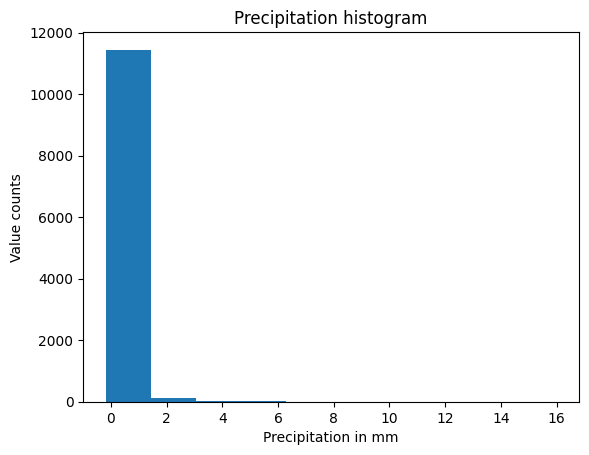

In [17]:
# TODO: plot a histogram after imputation
plt.hist(weather_data_imp['prcp'],)
plt.xlabel('Precipitation in mm')
plt.ylabel('Value counts')
plt.title('Precipitation histogram')
plt.show()

In [19]:
# TODO: safe data to data folder before imputation with name "weather_data_clean.csv"
weather_data.to_csv("../data/weather_data.csv")
# TODO: safe data to data folder before imputation with name "weather_data_imputed.csv"
weather_data_imp.to_csv("../data/weather_data_imp.csv")